In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

train = pd.read_csv('data/single_turbine_data/train_reduced_unskewed.csv')
test = pd.read_csv('data/single_turbine_data/test_reduced_unskewed.csv')

label = ['1_Gear oil temperature (°C)']

X_train = train.drop(label, axis=1)
y_train = train[label]
X_test = test.drop(label, axis=1)
y_test = test[label]

# convert to datetime
X_train['# Date and time'] = pd.to_datetime(X_train['# Date and time'])
X_test['# Date and time'] = pd.to_datetime(X_test['# Date and time'])
# y_train['# Date and time'] = pd.to_datetime(y_train['# Date and time'])
# y_test['# Date and time'] = pd.to_datetime(y_test['# Date and time'])

# Setting the index
X_train.set_index('# Date and time', inplace=True)
X_test.set_index('# Date and time', inplace=True)
# y_train.set_index('# Date and time', inplace=True)
# y_test.set_index('# Date and time', inplace=True)

In [10]:
original_cols = ['1_Wind direction (°)',
       '1_Nacelle position (°)', '1_Power (kW)',
       '1_Front bearing temperature (°C)', '1_Rear bearing temperature (°C)',
       '1_Stator temperature 1 (°C)', '1_Nacelle ambient temperature (°C)',
       '1_Nacelle temperature (°C)', '1_Transformer temperature (°C)',
       '1_Generator bearing rear temperature (°C)',
       '1_Generator bearing front temperature (°C)', '1_Temp. top box (°C)',
       '1_Hub temperature (°C)', '1_Ambient temperature (converter) (°C)',
       '1_Rotor bearing temp (°C)', '1_Transformer cell temperature (°C)', '1_Generator RPM (RPM)']
extras = ['month_sin', 'month_cos', 'hour_sin', 'hour_cos', 
# 'curtailed', 
# 'offline',
]
unskewed = [col for col in train.columns if col.endswith('unsk')]

# Create a set for each list of features
original_cols_set = set(original_cols)
extras_set = set(extras)
unskewed_set = set(unskewed)

# Remove the '_unsk' suffix from the unskewed features
unskewed_without_suffix = {feat.replace('unsk', '') for feat in unskewed_set}

# Subtract the unskewed set (without suffix) from the original set
# This will give you only the features in the original set that don't have an unskewed version
original_cols_without_unskewed = original_cols_set - unskewed_without_suffix

# Now create the final list of features
# This contains all the extra features, the unskewed features, and the original features that don't have an unskewed version
final_features = list(original_cols_without_unskewed | extras_set | unskewed_set)

In [11]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from pathlib import Path

# features = [col for col in X_train.columns if col not in original_cols]
# features = final_features
features = original_cols + extras
X_test = X_test[features]
X_train = X_train[features]
y_test.index = X_test.index
y_train.index = X_train.index

iterations = 10000
learning_rate = 0.01
depth = 7
theshold = 50
drop = ['1_Generator RPM (RPM)', '1_Temp. top box (°C)', '1_Nacelle ambient temperature (°C)',
       '1_Nacelle temperature (°C)']

# Filter data based on 'offline' and 'Curtailed' conditions
X_train_offline = X_train[X_train['1_Stator temperature 1 (°C)'] < theshold].drop(columns=drop, axis=1)
y_train_offline = y_train[X_train['1_Stator temperature 1 (°C)'] < theshold]

X_train_online = X_train[X_train['1_Stator temperature 1 (°C)'] > theshold]
y_train_online = y_train[X_train['1_Stator temperature 1 (°C)'] > theshold]

X_test_offline = X_test[X_test['1_Stator temperature 1 (°C)'] < theshold].drop(columns=drop, axis=1)
y_test_offline = y_test[X_test['1_Stator temperature 1 (°C)'] < theshold]

X_test_online = X_test[X_test['1_Stator temperature 1 (°C)'] > theshold]
y_test_online = y_test[X_test['1_Stator temperature 1 (°C)'] > theshold]

# Initialize CatBoost models
model_offline = CatBoostRegressor(iterations=iterations/5,
                                  learning_rate=learning_rate*2,
                                  depth=depth,
                                  loss_function='RMSE',
                                  random_seed=42,
                                  verbose=100)

model_online = CatBoostRegressor(iterations=iterations,
                                 learning_rate=learning_rate,
                                 depth=depth,
                                 loss_function='RMSE',
                                 random_seed=42,
                                 verbose=100)

# Fit the models
model_offline.fit(X_train_offline, y_train_offline, eval_set=(X_test_offline, y_test_offline))
model_online.fit(X_train_online, y_train_online, eval_set=(X_test_online, y_test_online))

# Make separate predictions for online and offline sets
y_test_pred_offline = model_offline.predict(X_test_offline)
y_test_pred_online = model_online.predict(X_test_online)

# Combine all the predictions and true labels
y_test_pred_combined = np.concatenate([y_test_pred_offline, y_test_pred_online])
y_test_combined = np.concatenate([y_test_offline, y_test_online])

# Calculate combined RMSE
rmse_combined = np.sqrt(mean_squared_error(y_test_combined, y_test_pred_combined))
print(f'Combined Validation RMSE: {rmse_combined}')

# Make separate predictions for the training sets for offline and online and calculate RMSE
y_train_pred_offline = model_offline.predict(X_train_offline)
y_train_pred_online = model_online.predict(X_train_online)
y_train_pred_combined = np.concatenate([y_train_pred_offline, y_train_pred_online])
y_train_combined = np.concatenate([y_train_offline, y_train_online])

rmse_train_combined = np.sqrt(mean_squared_error(y_train_combined, y_train_pred_combined))
print(f'Combined Train RMSE: {rmse_train_combined}')

# Save results
results_file = Path('results.csv')
results_df = pd.DataFrame(
    {
        'Model': ['CatBoost Combined'],
        'Training RMSE': [rmse_train_combined],
        'Validation RMSE': [rmse_combined],
        'Iterations': [iterations],
        'Learning Rate': [learning_rate],
        'Depth': [depth],
        'Loss Function': ['RMSE'],
        'Features': [features],
    }
)

if results_file.exists():
    existing_df = pd.read_csv(results_file)
    results_df = pd.concat([existing_df, results_df])

results_df.to_csv(results_file, index=False)

0:	learn: 8.3636656	test: 6.1668153	best: 6.1668153 (0)	total: 2.08ms	remaining: 4.16s
100:	learn: 1.9290631	test: 1.7742839	best: 1.7742839 (100)	total: 185ms	remaining: 3.48s
200:	learn: 1.1157427	test: 1.3392791	best: 1.3392791 (200)	total: 350ms	remaining: 3.13s
300:	learn: 0.9166840	test: 1.2801428	best: 1.2801281 (299)	total: 505ms	remaining: 2.85s
400:	learn: 0.8063921	test: 1.2566700	best: 1.2566700 (400)	total: 663ms	remaining: 2.64s
500:	learn: 0.7254782	test: 1.2409735	best: 1.2407532 (499)	total: 822ms	remaining: 2.46s
600:	learn: 0.6597084	test: 1.2285304	best: 1.2280917 (598)	total: 992ms	remaining: 2.31s
700:	learn: 0.6107315	test: 1.2215690	best: 1.2215690 (700)	total: 1.16s	remaining: 2.15s
800:	learn: 0.5714199	test: 1.2182984	best: 1.2182481 (799)	total: 1.33s	remaining: 1.99s
900:	learn: 0.5349799	test: 1.2125958	best: 1.2122533 (889)	total: 1.49s	remaining: 1.81s
1000:	learn: 0.5038590	test: 1.2106900	best: 1.2105501 (996)	total: 1.65s	remaining: 1.65s
1100:	learn:

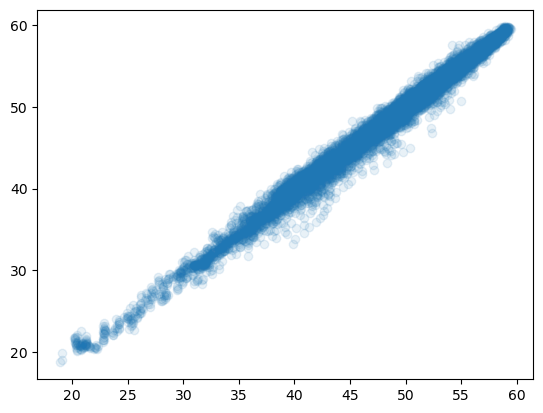

In [13]:
# plot y_test against best model predictions
import matplotlib.pyplot as plt

predictions = model_offline.predict(X_test_offline)
# test['GearOilunsk'] = test['1_Gear oil temperature (°C)'].apply(lambda x: x**(1/0.06))
# predictions = predictions**(0.06)

plt.scatter(predictions, y_test_offline, alpha=0.1)

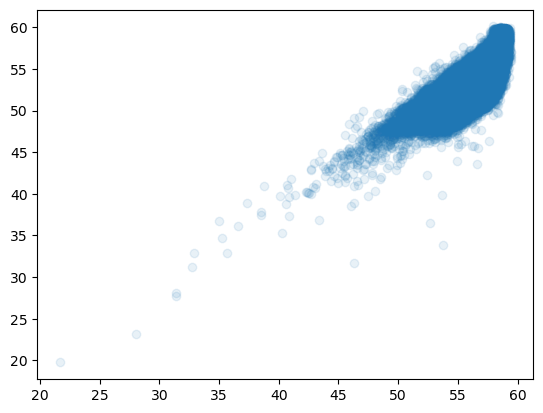

In [12]:
# plot y_test against best model predictions
import matplotlib.pyplot as plt

predictions = model_offline.predict(X_test_online)
# test['GearOilunsk'] = test['1_Gear oil temperature (°C)'].apply(lambda x: x**(1/0.06))
# predictions = predictions**(0.06)

plt.scatter(predictions, y_test_online, alpha=0.1)

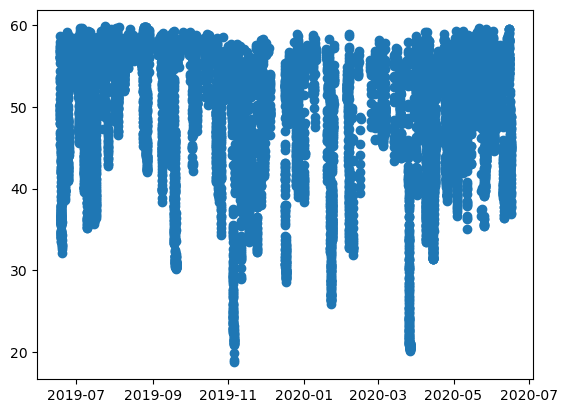

In [18]:
plt.scatter(y_test_offline.index, y_test_offline)

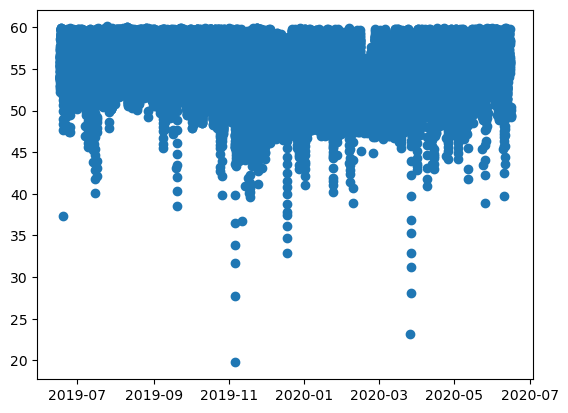

In [19]:
plt.scatter(y_test_online.index, y_test_online)

In [8]:
# create a numpy array for the range of reductions
reductions = np.linspace(0.1, 0.2, 10)
powers = np.linspace(2, 200, 50)

# iterate over each reduction value
for reduction in reductions:
    for power in powers:
        # reset predictions for each iteration
        pred_df = pd.DataFrame({'power': X_test['1_Power (kW)'], 'ambient_temp':X_test['1_Ambient temperature (converter) (°C)'], 'prediction': predictions, 'truth': y_test['1_Gear oil temperature (°C)']})
        pred_df = pred_df.reset_index(drop=True)

        # iterate over each row in the dataframe
        for i in range(1, len(pred_df)):
            # if power is less than 2
            if (pred_df.loc[i, 'power'] < power) and (pred_df.loc[i-1, 'power'] < power) and (pred_df.loc[i-1, 'power'] > pred_df.loc[i, 'power']):
                # calculate the new gear oil temp as the previous value minus the reduction
                new_gear_oil_temp = pred_df.loc[i-1, 'prediction'] - reduction
                # the gear oil temp should be the maximum of the new gear oil temp and the ambient temp
                pred_df.loc[i, 'prediction'] = max(new_gear_oil_temp, pred_df.loc[i, 'ambient_temp'])

        # calculate rmse between test['1_Gear oil temperature (°C)'] and pred_df['prediction']
        new_rmse = np.sqrt(mean_squared_error(test['1_Gear oil temperature (°C)'], pred_df['prediction']))
        print('Reduction: %.3f, Power: %.3f Test RMSE: %.3f' % (reduction, power, new_rmse))


ValueError: array length 52206 does not match index length 104412

In [ ]:
# print(len(X_test['1_Power (kW)']), X_test['1_Ambient temperature (converter) (°C)'], predictions, y_test['1_Gear oil temperature (°C)']))
print(len(X_test['1_Power (kW)']), len(X_test['1_Ambient temperature (converter) (°C)']), len(predictions), len(y_test['1_Gear oil temperature (°C)']))

52206 52206 52206 52206


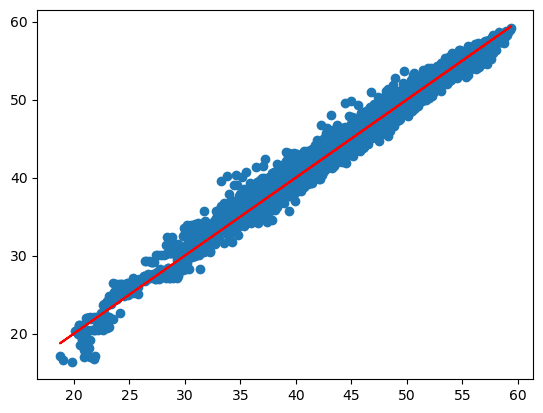

In [ ]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
predictions_series = pd.Series(predictions)  # If predictions is not already a series

pred_df = pd.DataFrame({
    'power': X_test_reset['1_Power (kW)'],
    'ambient_temp': X_test_reset['1_Ambient temperature (converter) (°C)'],
    'prediction': predictions_series,
    'truth': y_test_reset['1_Gear oil temperature (°C)']
})

pred_df_low = pred_df[pred_df['power'] < 10]
plt.scatter(pred_df_low['truth'], pred_df_low['prediction'])
plt.plot(pred_df_low['truth'], pred_df_low['truth'], color='red')

(array([  2.,   5.,   2.,   1.,   3.,   2.,   7.,   5.,   9.,  20.,  12.,
          4.,   0.,  22.,   3.,   0.,   0.,   6.,   4.,   4.,   5.,   9.,
          6.,  15.,   8.,  30.,  14.,   7.,   6.,   5.,  11.,  14.,  20.,
         27.,  16.,  49.,  18.,  17.,  37.,  34.,  50.,  46.,  32.,  30.,
         41.,  59.,  58.,  62.,  63.,  41.,  73.,  77., 110., 100., 110.,
        110., 110., 111., 106.,  98., 110., 128., 120., 121., 101., 112.,
        103., 108., 136., 125., 134., 136., 138., 122., 130., 126., 147.,
        137., 138., 101., 102., 101., 127.,  99., 108.,  92.,  86.,  99.,
         93.,  93.,  76.,  68.,  67.,  69.,  49.,  33.,  19.,  19.,   7.,
          4.]),
 array([16.28647716, 16.71557888, 17.14468061, 17.57378234, 18.00288406,
        18.43198579, 18.86108752, 19.29018924, 19.71929097, 20.1483927 ,
        20.57749442, 21.00659615, 21.43569788, 21.8647996 , 22.29390133,
        22.72300306, 23.15210478, 23.58120651, 24.01030824, 24.43940996,
        24.86851169, 25.29

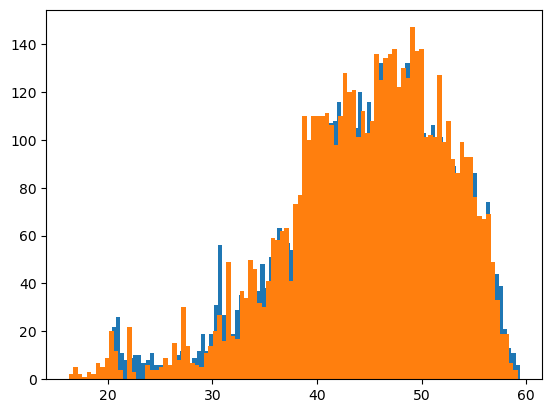

In [ ]:
plt.hist(pred_df_low['truth'], bins=100)
plt.hist(pred_df_low['prediction'], bins=100)

In [ ]:
rmse = np.sqrt(mean_squared_error(test['1_Gear oil temperature (°C)'], predictions))
print('RMSE: %.3f' % rmse)
new_rmse = np.sqrt(mean_squared_error(test['1_Gear oil temperature (°C)'], pred_df['prediction']))
print('Test RMSE: %.3f' % new_rmse)

RMSE: 0.543
Test RMSE: 0.543


In [ ]:
df = test.copy()
df['predictions'] = predictions
df['residuals'] = abs(df['1_Gear oil temperature (°C)'] - df['predictions'])

In [ ]:
# order by abs(residuals)
df = df.sort_values(by=['residuals'], ascending=False)

In [ ]:
# show all colmns
pd.set_option('display.max_columns', None)
df.head(100)

,# Date and time,1_Wind direction (°),1_Nacelle position (°),1_Power (kW),1_Front bearing temperature (°C),1_Rear bearing temperature (°C),1_Stator temperature 1 (°C),1_Nacelle ambient temperature (°C),1_Nacelle temperature (°C),1_Transformer temperature (°C),1_Generator bearing rear temperature (°C),1_Generator bearing front temperature (°C),1_Temp. top box (°C),1_Hub temperature (°C),1_Ambient temperature (converter) (°C),1_Rotor bearing temp (°C),1_Transformer cell temperature (°C),1_Generator RPM (RPM),1_Gear oil temperature (°C),curtailed,offline,1_Transformer temperature (°C)unsk,1_Generator bearing front temperature (°C)unsk,1_Generator bearing rear temperature (°C)unsk,1_Front bearing temperature (°C)unsk,1_Rear bearing temperature (°C)unsk,month_sin,month_cos,hour_sin,hour_cos,predictions,residuals
20291,2019-11-05 16:40:00,7.923234,3.853868,1351.550928,79.855000,64.405001,37.925000,9.300000,11.470000,36.127500,35.047500,45.655000,14.312500,15.0000,9.992500,17.657500,13.800000,1760.853218,33.830000,False,False,4.798044,5.197670,4.747390,6.217750,5.814362,-0.500000,8.660254e-01,-8.660254e-01,-0.500000,44.435880,10.605880
20289,2019-11-05 16:20:00,1.322151,3.853868,1322.399167,64.112501,52.952500,24.800000,9.390000,12.020000,29.855000,22.830000,30.170000,13.900000,14.9980,9.755000,14.460000,13.622500,1767.634644,27.777500,False,False,4.484173,4.501175,4.060310,5.805974,5.459135,-0.500000,8.660254e-01,-8.660254e-01,-0.500000,36.636710,8.859210
20290,2019-11-05 16:30:00,5.916359,3.853868,1388.663480,77.537500,61.575001,31.497500,9.297500,11.952500,32.790000,30.105000,40.487500,14.032500,15.0000,9.817500,16.155000,13.740000,1778.755594,31.650000,False,False,4.637199,4.990589,4.497679,6.161669,5.731825,-0.500000,8.660254e-01,-8.660254e-01,-0.500000,39.146254,7.496254
31591,2020-01-23 05:00:00,217.180615,217.878296,2.397443,47.902632,42.434211,41.323685,7.052632,15.321053,30.071052,33.386842,29.026316,20.942105,16.0000,8.989474,17.768421,11.481579,968.688379,33.242105,False,True,4.495850,4.438729,4.666926,5.281701,5.071048,0.500000,8.660254e-01,9.659258e-01,0.258819,39.613483,6.371378
31592,2020-01-23 05:10:00,214.641885,217.878296,3.590022,45.005000,43.682500,43.162500,7.115000,15.650000,30.080000,34.892500,29.522500,21.002500,16.0000,9.002500,18.265000,11.485000,968.659470,33.817499,False,True,4.496333,4.466065,4.740014,5.172728,5.121041,0.500000,8.660254e-01,9.659258e-01,0.258819,40.176348,6.358849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18882,2019-10-26 11:30:00,266.442288,250.859485,14.764443,63.402500,58.042500,50.047500,13.207500,22.257500,39.590000,34.205000,34.800000,25.535000,20.0000,13.615000,26.487500,16.610000,595.550379,47.410000,False,True,4.952410,4.735600,4.706971,5.785478,5.624227,-0.866025,5.000000e-01,2.588190e-01,-0.965926,50.734456,3.324455
31658,2020-01-23 16:10:00,257.000475,256.293060,32.709965,44.932500,48.655000,53.825000,6.802500,19.020000,29.875000,38.410000,37.339999,25.275000,16.0000,9.197500,20.162500,11.302500,969.022533,38.387501,False,True,4.485257,4.853441,4.901105,5.169927,5.309096,0.500000,8.660254e-01,-8.660254e-01,-0.500000,41.679766,3.292265
21849,2019-11-16 12:20:00,210.477773,12.634347,0.001000,35.690000,33.190001,42.760000,9.432500,18.630000,30.752500,34.065001,32.220001,24.000000,15.9715,12.342500,18.725000,12.407500,27.844900,37.830000,False,True,4.532235,4.608389,4.700175,4.777677,4.657170,-0.500000,8.660254e-01,1.224647e-16,-1.000000,34.544651,3.285348
31663,2020-01-23 17:00:00,258.540045,269.463837,0.001000,44.345000,48.080000,60.110000,6.927500,19.685001,29.847500,41.922500,39.807500,25.602500,16.5500,9.037500,21.180001,11.157500,453.990429,39.860000,False,True,4.483766,4.961727,5.050200,5.147094,5.288191,0.500000,8.660254e-01,-9.659258e-01,-0.258819,43.133926,3.273926


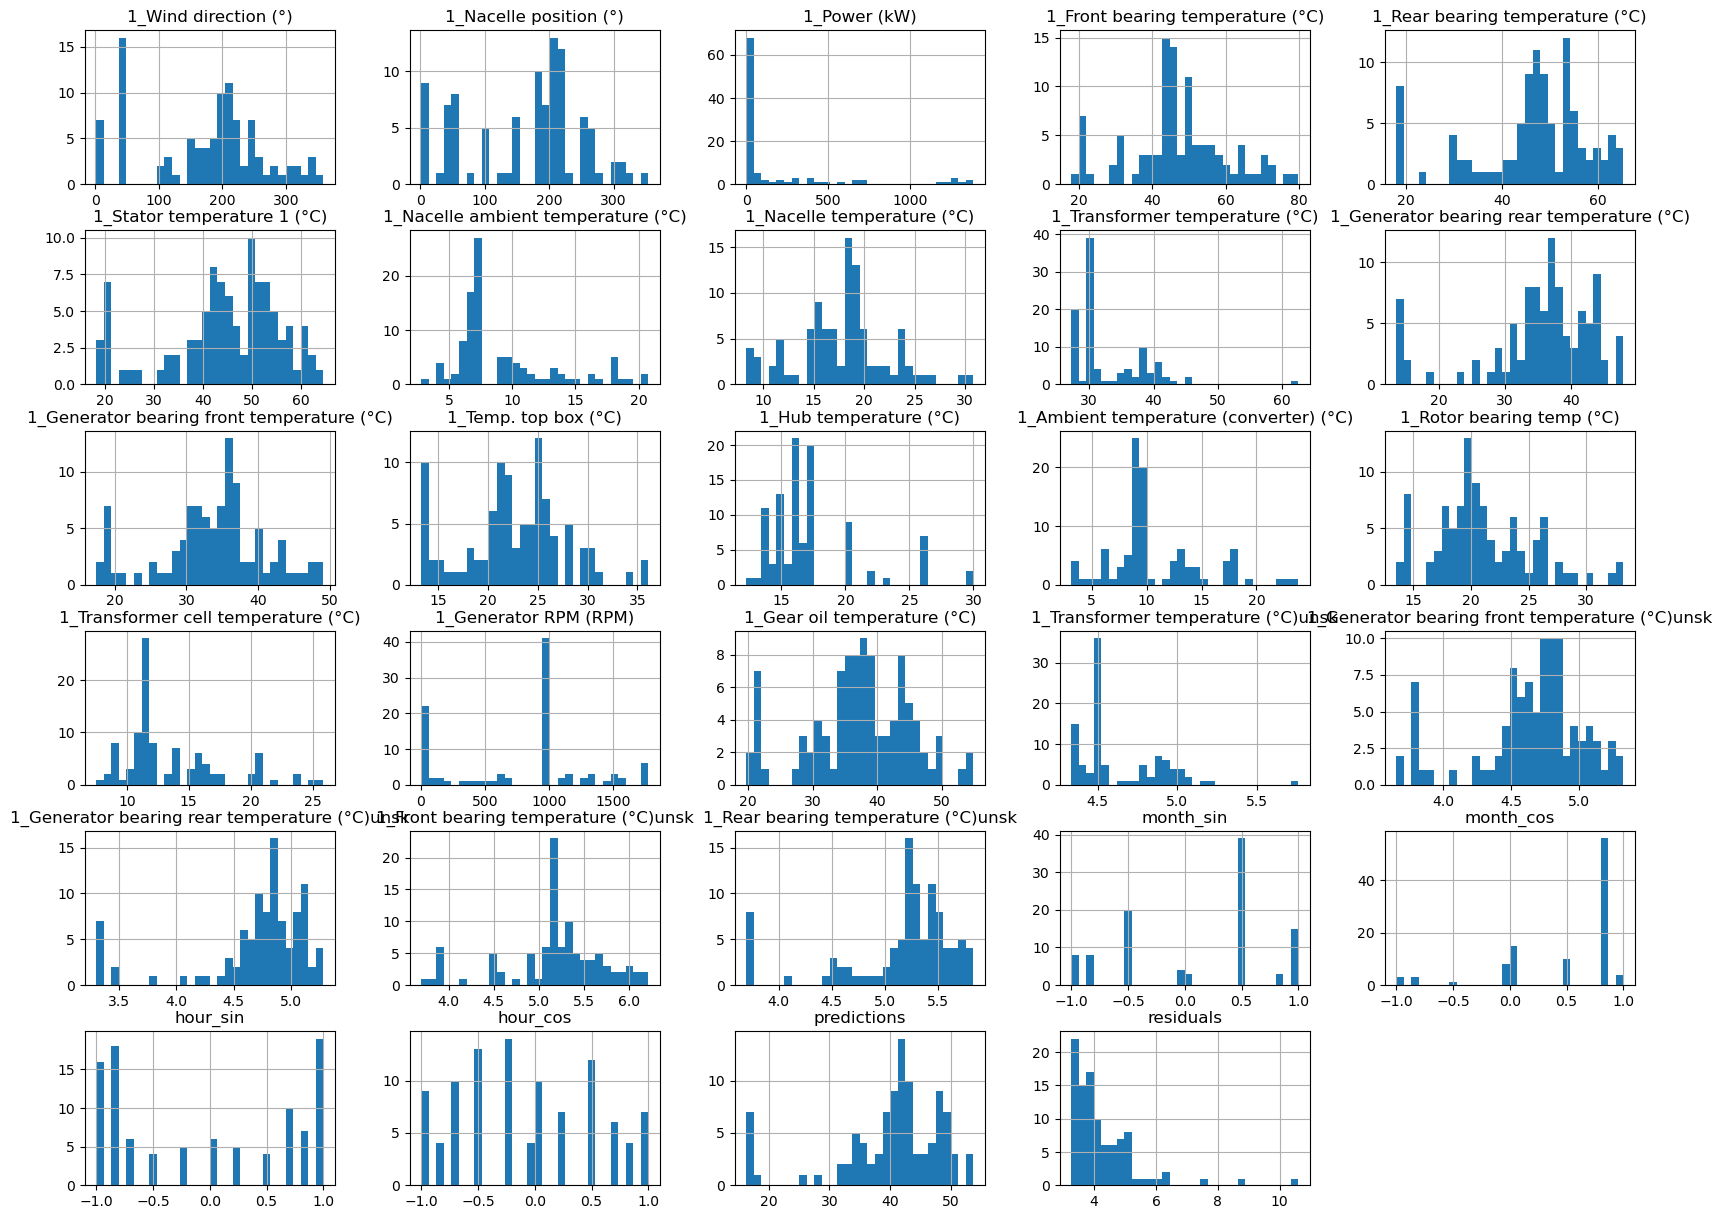

In [ ]:
# histogram of the reduced data
diffs = df.head(100)
# Histograms for all variables in the dataframe
diffs.hist(bins=30, figsize=(20,15))
plt.show()